In [ ]:
import os, re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)

ROOT = "validate_model"
DATA = os.path.join(ROOT, "data")
OUT  = os.path.join(ROOT, "outputs")
os.makedirs(OUT, exist_ok=True)

curva_paths = sorted(glob.glob(os.path.join(DATA, "demanda_efetiva", "CURVA_CARGA_*_2025.csv")))
prev_paths  = sorted(glob.glob(os.path.join(DATA, "demanda_esperada", "DEMANDA_*_2025.csv")))

solar_path   = os.path.join(DATA, "producao_solar", "fotovoltaicas_2025.csv")
wind_path    = os.path.join(DATA, "producao_eolica", "eolicas_2025.csv")
nuclear_path = os.path.join(DATA, "producao_non_renewable", "nuclear_2025.csv")
term_path    = os.path.join(DATA, "producao_non_renewable", "TERMICAS_2025.csv")

print("curva_paths:", curva_paths)
print("prev_paths :", prev_paths)
print("solar:", os.path.exists(solar_path), solar_path)
print("wind :", os.path.exists(wind_path), wind_path)
print("nuclear:", os.path.exists(nuclear_path), nuclear_path)
print("termicas:", os.path.exists(term_path), term_path)


curva_paths: ['validate_model\\data\\demanda_efetiva\\CURVA_CARGA_NORTE_2025.csv', 'validate_model\\data\\demanda_efetiva\\CURVA_CARGA_SUDESTE_2025.csv', 'validate_model\\data\\demanda_efetiva\\CURVA_CARGA_SUL_2025.csv']
prev_paths : ['validate_model\\data\\demanda_esperada\\DEMANDA_NE_2025.csv', 'validate_model\\data\\demanda_esperada\\DEMANDA_N_2025.csv', 'validate_model\\data\\demanda_esperada\\DEMANDA_S_2025.csv']
solar: True validate_model\data\producao_solar\fotovoltaicas_2025.csv
wind : True validate_model\data\producao_eolica\eolicas_2025.csv
nuclear: True validate_model\data\producao_non_renewable\nuclear_2025.csv
termicas: True validate_model\data\producao_non_renewable\TERMICAS_2025.csv


In [ ]:
import unicodedata

SUBSYS = {"norte":"N","nordeste":"NE","sudeste":"SE","sul":"S","n":"N","ne":"NE","se":"SE","s":"S"}

def norm(s: str) -> str:
    s = str(s).strip()
    s = unicodedata.normalize("NFKD", s).encode("ascii","ignore").decode("ascii")
    s = s.lower()
    s = re.sub(r"[^a-z0-9]+", "_", s)
    s = re.sub(r"_+","_", s).strip("_")
    return s

def canonical_subsys(x: str):
    if x is None: return None
    k = norm(x).replace("_","")
    for key,val in SUBSYS.items():
        kk = key.replace("_","")
        if k == kk or k.endswith(kk) or kk in k:
            return val
    return None

def subsys_from_filename(path: str):
    fn = norm(os.path.basename(path))
    for token in ["norte","nordeste","sudeste","sul","ne","se","n","s"]:
        if token in fn:
            return canonical_subsys(token)
    return None

def read_csv_robust(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Arquivo não encontrado: {path}")
    last = None
    for enc in ["utf-8","latin1"]:
        try:
            df = pd.read_csv(path, sep=None, engine="python", encoding=enc)
            break
        except Exception as e:
            last = e
            df = None
    if df is None:
        raise RuntimeError(f"Falha ao ler {path}. Último erro: {last}")

    # corrige "EÃ³lica" etc
    for c in df.select_dtypes(include=["object"]).columns:
        s = df[c].astype(str)
        try:
            fixed = s.str.encode("latin1", errors="ignore").str.decode("utf-8", errors="ignore")
            if fixed.str.contains("Ã").mean() < s.str.contains("Ã").mean():
                df[c] = fixed
        except Exception:
            pass

    df.columns = [norm(c) for c in df.columns]
    return df

def to_float(x: pd.Series) -> pd.Series:
    s = x.astype(str).str.strip()
    s = s.str.replace(r"(?<=\d)\.(?=\d{3}(\D|$))","", regex=True)  
    s = s.str.replace(",",".", regex=False)
    return pd.to_numeric(s, errors="coerce")

def detect_datetime_col(df):
    cands = [c for c in df.columns if any(k in c for k in ["din_instante","data","hora","datetime","timestamp"])]
    return cands[0] if cands else None

def detect_load_col(df):
    if "val_cargaenergiahomwmed" in df.columns: return "val_cargaenergiahomwmed"
    cands = [c for c in df.columns if any(k in c for k in ["carga","demanda","mwmed","load","mw"])]
    return cands[0] if cands else None

def detect_gen_col(df):
    if "val_geracao" in df.columns: return "val_geracao"
    cands = [c for c in df.columns if any(k in c for k in ["geracao","generation"])]
    return cands[0] if cands else None

def detect_subsys_col(df):
    for c in ["id_subsistema","cod_subsistema","nom_subsistema","subsistema"]:
        if c in df.columns:
            return c
    return None


In [56]:
def load_demanda_efetiva(paths):
    out = []
    for p in paths:
        df = read_csv_robust(p)
        dtc = detect_datetime_col(df)
        lc  = detect_load_col(df)
        if dtc is None or lc is None:
            raise ValueError(f"[{p}] não achei datetime/carga. cols={df.columns.tolist()}")
        ss = subsys_from_filename(p)

        d = pd.DataFrame()
        d["din_instante"] = pd.to_datetime(df[dtc], errors="coerce").dt.floor("H")
        d["D"] = to_float(df[lc])
        if "id_subsistema" in df.columns:
            d["id_subsistema"] = df["id_subsistema"].astype(str).str.strip().apply(canonical_subsys).fillna(ss)
        else:
            d["id_subsistema"] = ss
        d = d.dropna(subset=["din_instante","id_subsistema","D"])
        d = d.groupby(["din_instante","id_subsistema"], as_index=False)["D"].mean()
        out.append(d)
    return pd.concat(out, ignore_index=True)

def load_demanda_prevista(paths):
    out = []
    for p in paths:
        df = read_csv_robust(p)
        # tenta achar colunas
        day_col = None
        for c in df.columns:
            if any(k in c for k in ["din_programacaodia","programacao","dia","data"]):
                day_col = c; break
        pat_col = next((c for c in df.columns if "patamar" in c), None)
        val_col = "val_demanda" if "val_demanda" in df.columns else next((c for c in df.columns if "demanda" in c or "carga" in c), None)

        if day_col is None or pat_col is None or val_col is None:
            raise ValueError(f"[{p}] não achei dia/patamar/demanda. cols={df.columns.tolist()}")

        ss = subsys_from_filename(p)
        dd = pd.DataFrame()
        dd["dia"] = pd.to_datetime(df[day_col], errors="coerce").dt.date
        dd["patamar"] = pd.to_numeric(df[pat_col], errors="coerce")
        dd["D_prev_pat"] = to_float(df[val_col])

        if "cod_subsistema" in df.columns:
            dd["id_subsistema"] = df["cod_subsistema"].astype(str).str.strip().apply(canonical_subsys).fillna(ss)
        else:
            dd["id_subsistema"] = ss

        dd = dd.dropna(subset=["dia","patamar","D_prev_pat","id_subsistema"])
        dd = dd.groupby(["id_subsistema","dia","patamar"], as_index=False)["D_prev_pat"].mean()
        out.append(dd)

    return pd.concat(out, ignore_index=True)

def load_generation(path, fonte):
    df = read_csv_robust(path)
    dtc = detect_datetime_col(df)
    vc  = detect_gen_col(df)
    sc  = detect_subsys_col(df)
    if dtc is None or vc is None or sc is None:
        raise ValueError(f"[{path}] não achei (datetime, val_geracao, subsistema). cols={df.columns.tolist()}")

    g = pd.DataFrame()
    g["din_instante"] = pd.to_datetime(df[dtc], errors="coerce").dt.floor("H")
    g["val_geracao"]  = to_float(df[vc])
    g["id_subsistema"] = df[sc].astype(str).str.strip().apply(canonical_subsys)

    g["fonte"] = fonte
    g = g.dropna(subset=["din_instante","id_subsistema","val_geracao"])
    g = g.groupby(["din_instante","id_subsistema","fonte"], as_index=False)["val_geracao"].sum()
    return g

D_eff  = load_demanda_efetiva(curva_paths)
D_prev = load_demanda_prevista(prev_paths)

G_sol  = load_generation(solar_path, "solar")
G_win  = load_generation(wind_path, "wind")
G_nuc  = load_generation(nuclear_path, "nuclear") if os.path.exists(nuclear_path) else pd.DataFrame(columns=["din_instante","id_subsistema","fonte","val_geracao"])
G_ter  = load_generation(term_path, "thermal")   if os.path.exists(term_path)   else pd.DataFrame(columns=["din_instante","id_subsistema","fonte","val_geracao"])

G_all = pd.concat([G_sol, G_win, G_nuc, G_ter], ignore_index=True)

G_piv = (G_all.pivot_table(index=["din_instante","id_subsistema"], columns="fonte",
                           values="val_geracao", aggfunc="sum")
              .fillna(0.0).reset_index())

panel = (G_piv.merge(D_eff, on=["din_instante","id_subsistema"], how="inner")
             .sort_values(["id_subsistema","din_instante"])
             .reset_index(drop=True))

panel["gs"] = panel.get("solar", 0.0)
panel["gr"] = panel.get("wind", 0.0)
panel["g_nuc_obs"] = panel.get("nuclear", 0.0)
panel["g_th_obs"]  = panel.get("thermal", 0.0)
panel["gn_obs"]    = panel["g_nuc_obs"] + panel["g_th_obs"]

panel.head()


C:\Users\joaof\AppData\Local\Temp\ipykernel_21580\3509690120.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  d["din_instante"] = pd.to_datetime(df[dtc], errors="coerce").dt.floor("H")
C:\Users\joaof\AppData\Local\Temp\ipykernel_21580\3509690120.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  d["din_instante"] = pd.to_datetime(df[dtc], errors="coerce").dt.floor("H")
C:\Users\joaof\AppData\Local\Temp\ipykernel_21580\3509690120.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  d["din_instante"] = pd.to_datetime(df[dtc], errors="coerce").dt.floor("H")
C:\Users\joaof\AppData\Local\Temp\ipykernel_21580\3509690120.py:64: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  g["din_instante"] = pd.to_datetime(df[dtc], errors="coerce").dt.floor("H")
C:\Users\joaof\AppData\Local

,din_instante,id_subsistema,nuclear,solar,thermal,wind,D,gs,gr,g_nuc_obs,g_th_obs,gn_obs
0,2025-01-01 00:00:00,N,0.0,0.0,2055084.99,14662529.62,7097.751,0.0,14662529.62,0.0,2055084.99,2055084.99
1,2025-01-01 01:00:00,N,0.0,0.0,1847169.19,14608597.87,7053337.000,0.0,14608597.87,0.0,1847169.19,1847169.19
2,2025-01-01 02:00:00,N,0.0,0.0,1967127.47,15076238.35,7244.130,0.0,15076238.35,0.0,1967127.47,1967127.47
3,2025-01-01 03:00:00,N,0.0,0.0,1938407.02,15252788.41,7255306.000,0.0,15252788.41,0.0,1938407.02,1938407.02
4,2025-01-01 04:00:00,N,0.0,8244.0,1790977.06,16218163.69,7232931.000,8244.0,16218163.69,0.0,1790977.06,1790977.06


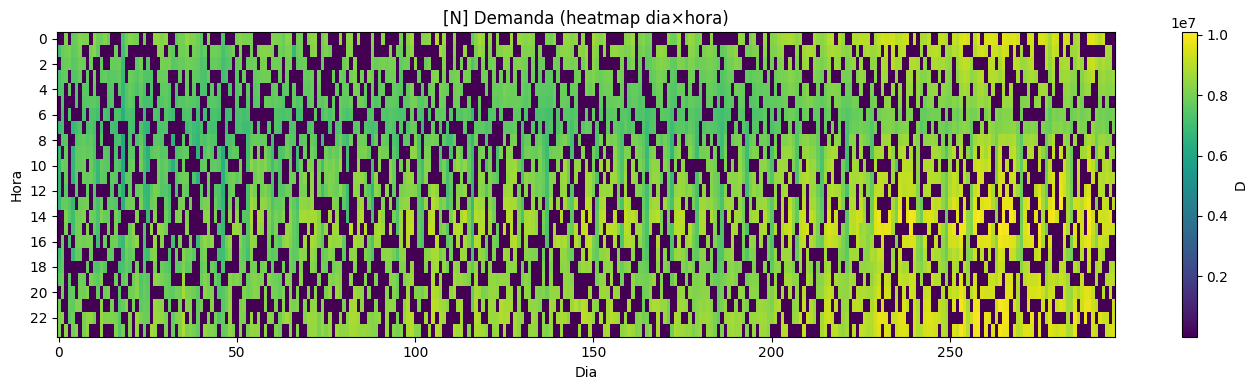

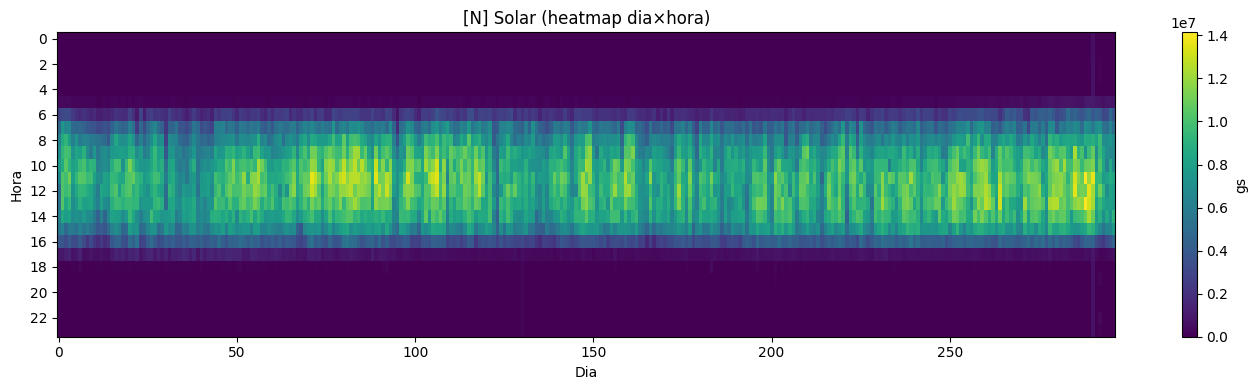

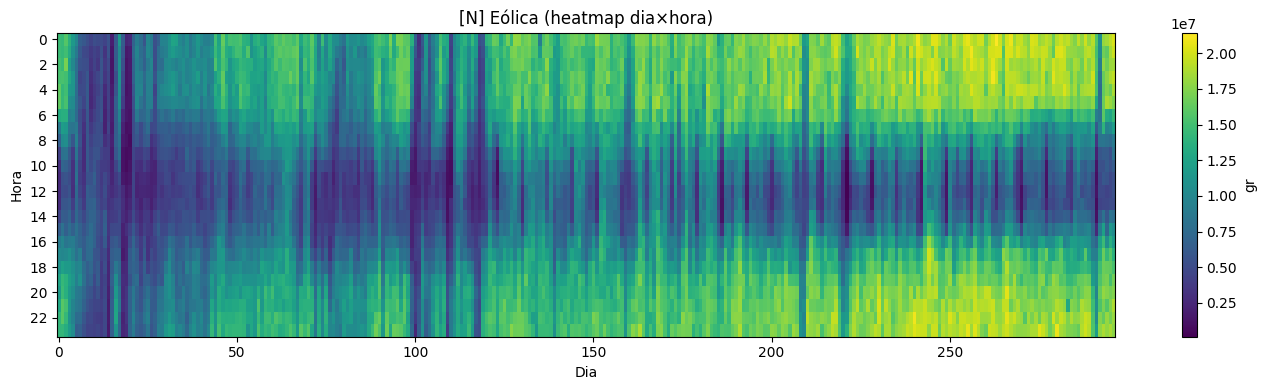

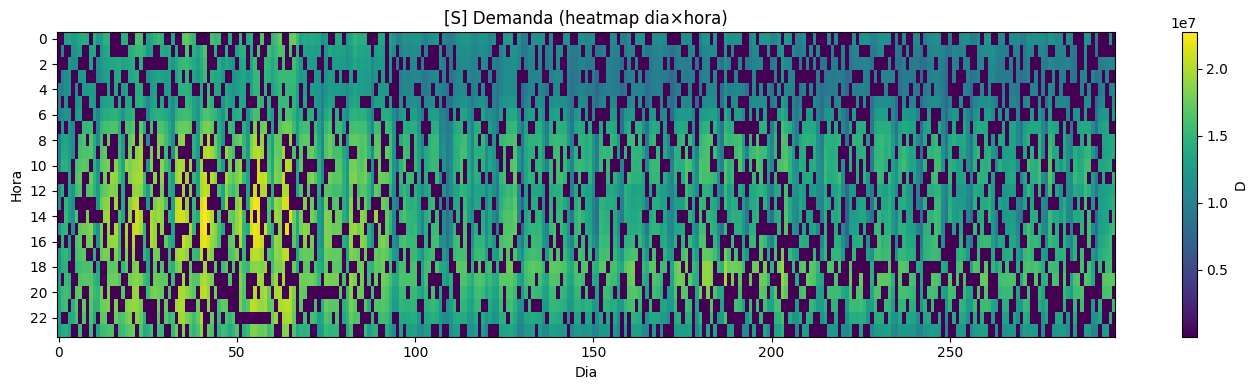

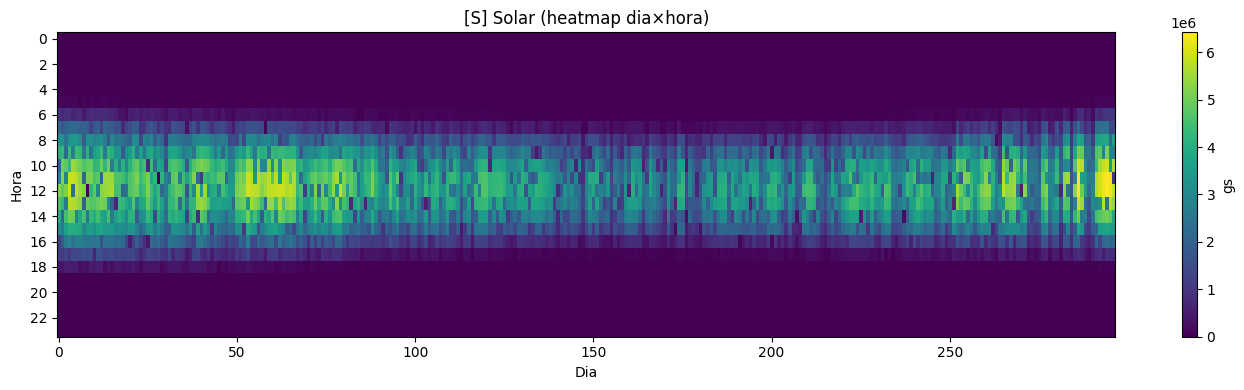

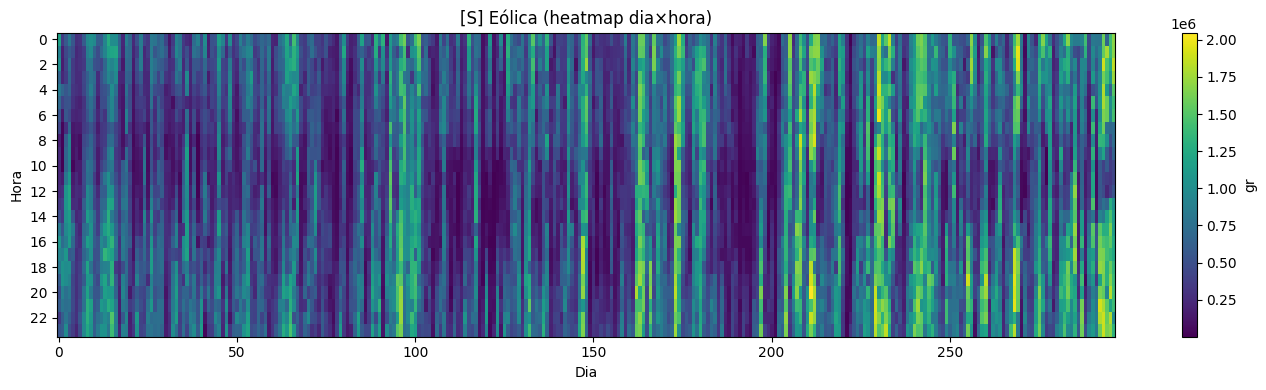

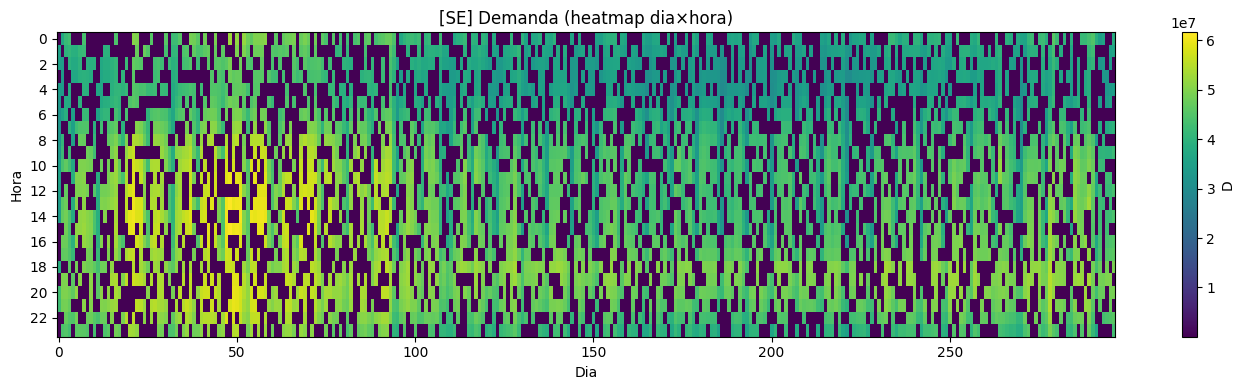

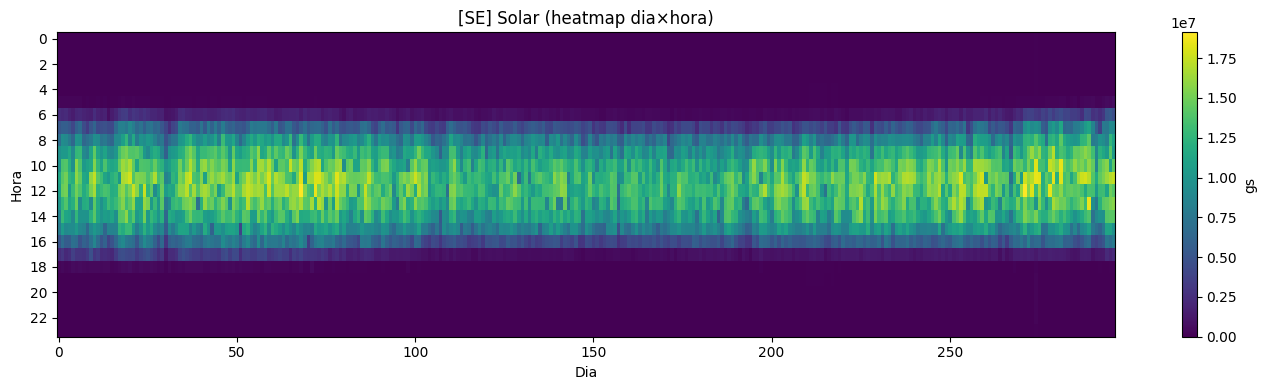

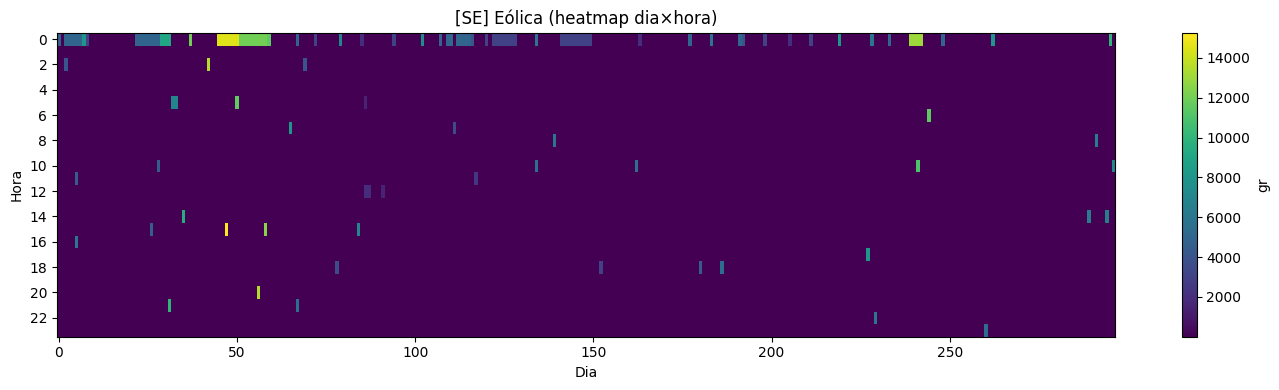

In [57]:
def heatmap_day_hour(df, value_col, ss, title, agg="mean"):
    g = df[df["id_subsistema"]==ss].copy()
    g["dia"] = g["din_instante"].dt.date
    g["hora"] = g["din_instante"].dt.hour
    piv = g.pivot_table(index="hora", columns="dia", values=value_col, aggfunc=agg).sort_index()
    plt.figure(figsize=(14,4))
    plt.imshow(piv.values, aspect="auto", interpolation="nearest")
    plt.colorbar(label=value_col)
    plt.yticks(range(0,24,2), range(0,24,2))
    plt.title(f"[{ss}] {title}")
    plt.xlabel("Dia")
    plt.ylabel("Hora")
    plt.tight_layout()
    plt.show()

for ss in sorted(panel["id_subsistema"].unique()):
    heatmap_day_hour(panel, "D",  ss, "Demanda (heatmap dia×hora)")
    heatmap_day_hour(panel, "gs", ss, "Solar (heatmap dia×hora)")
    heatmap_day_hour(panel, "gr", ss, "Eólica (heatmap dia×hora)")


Produzimos heatmaps \( \text{dia} \times \text{hora} \) para inspecionar padrões temporais das séries observadas no painel `panel`. Trata-se de uma validação qualitativa do comportamento esperado das variáveis exógenas do modelo do PDF, principalmente \(g^s\) (solar) e \(g^r\) (eólica), que no modelo são componentes fundamentais do balanço.


O modelo do PDF assume que o sistema segue um balanço com fontes renováveis (solar/eólica) e um bloco controlável \(g^n\). Para que a validação do despacho faça sentido, os termos renováveis precisam ter **forma temporal coerente**:

- Solar deve apresentar:
  $$
  g^s_{t,s} \approx 0 \text{ (noite)}, \quad g^s_{t,s} > 0 \text{ (faixa diurna)},
  $$
  com sazonalidade ao longo do ano.

- Eólica deve apresentar variabilidade diária/horária mais “difusa”, muitas vezes com regimes persistentes (listras verticais por dias bons/ruins) e eventual estrutura horária dependendo da região.

- Demanda deve apresentar padrões intradiários (picos e vales) e sazonalidade.

Esses padrões são pré-requisitos para interpretar corretamente:
- curtailment \(c_{t,s}\),
- déficit \(u_{t,s}\),
- e o multiplicador dual \(\lambda_{t,s}\) do balanço.

#### 3.1 `[N] Solar (heatmap dia×hora)`
O heatmap exibiu uma faixa clara de geração em torno do período diurno (aproximadamente 7h–16h) e valores próximos de zero durante a noite. Esse é exatamente o comportamento físico esperado de \(g^s\). A variação ao longo do eixo “dia” indica sazonalidade e/ou variação climática, o que é plausível.


#### 3.2 `[N] Eólica (heatmap dia×hora)`
O heatmap mostra grande variabilidade por dia (listras verticais), além de diferenças por hora (alguns horários consistentemente mais fortes/fracos). Esse padrão é compatível com eólica real, que é altamente estocástica e pode apresentar regimes de vento persistentes por alguns dias.

#### 3.3 `[S] Eólica (heatmap dia×hora)`
O Sul exibiu uma textura ainda mais “pontilhada/variável”, com muita intermitência. Isso também é plausível, dependendo do mix eólico e da meteorologia local.


#### 3.4 `[SE] Eólica (heatmap dia×hora)` quase tudo zerado
O Sudeste apareceu quase todo “escuro” (próximo de zero) com alguns picos isolados. Isso sugere:

- baixa cobertura de eólicas no SE no dataset, **ou**
- falha de mapeamento do subsistema (linhas do SE indo parar em outro subsistema), **ou**
- valores ausentes/filtrados.


Aqui validamos que as séries renováveis apresentam padrões temporais qualitativamente coerentes (especialmente solar), e também diagnostica potenciais problemas de cobertura/mapeamento (eólica no SE). Essas evidências são fundamentais para interpretar corretamente, mais adiante, as variáveis endógenas do modelo do PDF (\(g^n\), \(c\), \(u\), \(\lambda\)) e para calibrar corretamente a variância do erro agregado renovável \(\sigma_\epsilon(t)\) quando você introduz reserva.


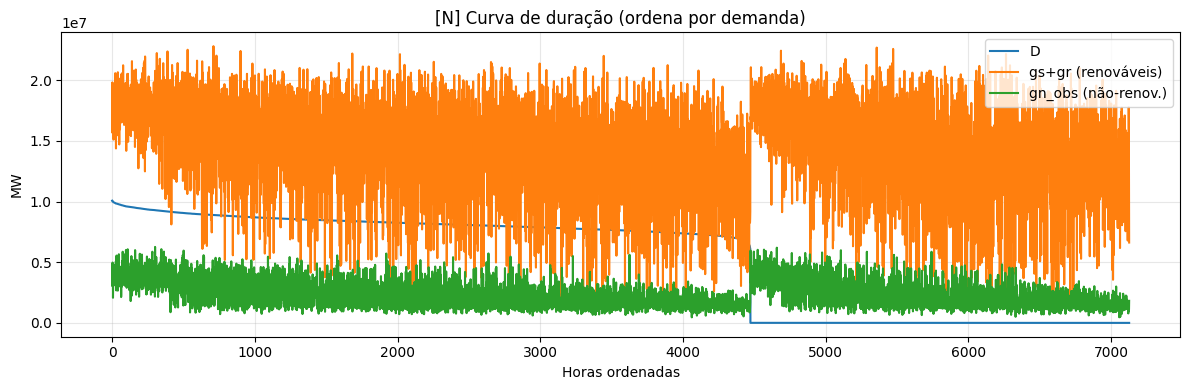

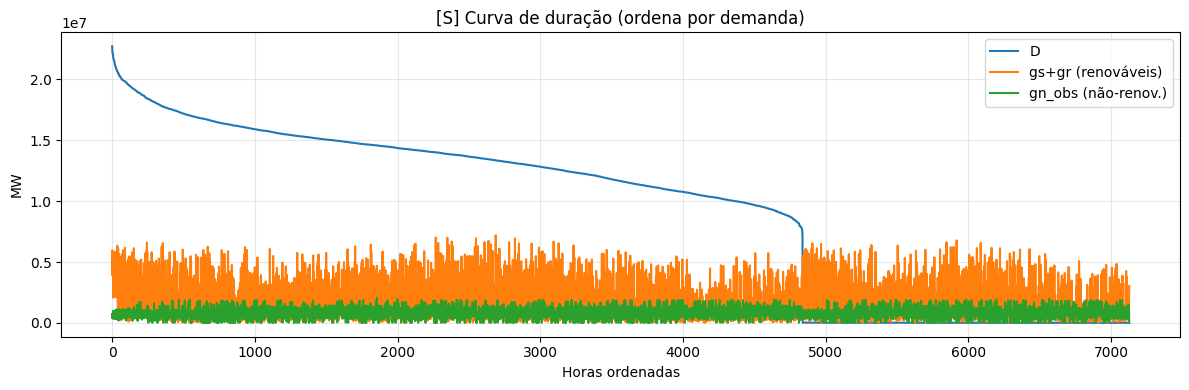

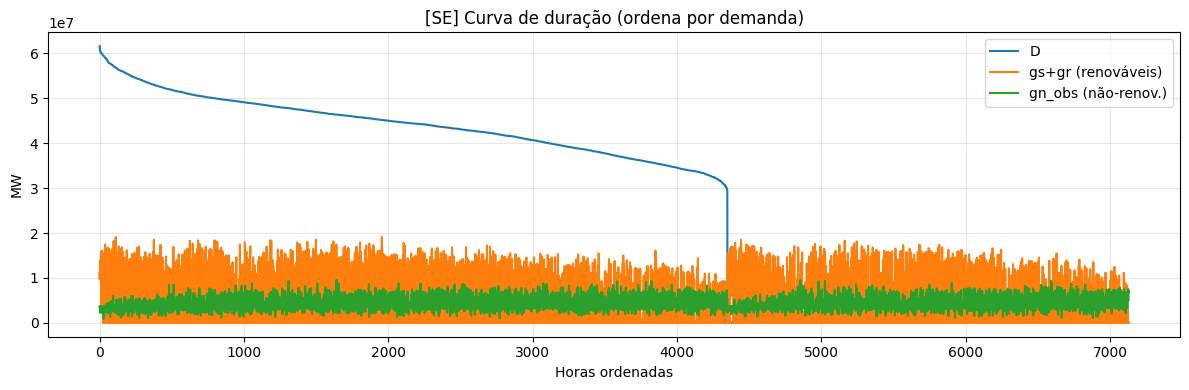

In [58]:
def load_duration(df, ss):
    g = df[df["id_subsistema"]==ss].copy()
    g = g.sort_values("D", ascending=False).reset_index(drop=True)
    x = np.arange(len(g))
    plt.figure(figsize=(12,4))
    plt.plot(x, g["D"].values, label="D")
    plt.plot(x, (g["gs"]+g["gr"]).values, label="gs+gr (renováveis)")
    plt.plot(x, g["gn_obs"].values, label="gn_obs (não-renov.)")
    plt.title(f"[{ss}] Curva de duração (ordena por demanda)")
    plt.xlabel("Horas ordenadas")
    plt.ylabel("MW")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

for ss in sorted(panel["id_subsistema"].unique()):
    load_duration(panel, ss)


Esta célula gera, por subsistema, a curva de duração , ordenando as horas pelo nível de demanda observada e comparando a demanda com a oferta renovável e não renovável observada.

Para um subsistema \(s\), temos \(T\) horas. Defina \(D_{t,s}\) e reordene os índices \(t\) por demanda decrescente:
$$
D_{(1),s} \ge D_{(2),s} \ge \dots \ge D_{(T),s}.
$$

Em seguida, plota-se:

- Demanda: \(D_{(k),s}\)
- Renováveis agregadas: \((g^s + g^r)_{(k),s}\)
- Não renovável observada: \(g^n_{(k),s}\)

onde \(g^n = gn\_obs\) no seu painel.

Queremos verificar:

- se renováveis estão frequentemente acima/abaixo da demanda;
- quando o sistema depende de \(g^n\) para atender picos;
- quão “difícil” é atender a cauda de alta demanda.

Em termos do balanço:
$$
g^s_{t,s}+g^r_{t,s}+g^n_{t,s} \approx D_{t,s} \quad (\text{se } c=u=0),
$$
mas quando há excedente ou falta:
$$
g^s_{t,s}+g^r_{t,s}+g^n_{t,s} = D_{t,s} + c_{t,s} - u_{t,s}.
$$

A curva de duração valida a estrutura de distribuição (picos vs base) e indica, de forma clara, se o sistema está “renovável-dominante” ou “controlável-dominante”. No seu resultado, a divergência extrema entre \(gs+gr\) e \(D\). TODO Verificar consistências de unidades


In [ ]:
from dataclasses import dataclass

@dataclass
class Params:
    # limites físicos
    Kn: float
    rho: float
    # custos
    c1: float = 0.0
    c2: float = 1e-4
    gamma: float = 5.0
    # penalidades desequilíbrio
    pi_u: float = 1e4
    pi_c: float = 10.0
    # reserva
    alpha: float = 0.05     # 95% de confiabilidade
    kappa: float = 1.0     

def estimate_Kn_rho(gn_obs):
    g = np.asarray(gn_obs)
    g = g[np.isfinite(g)]
    if len(g) < 10:
        return 0.0, 0.0
    Kn  = float(np.quantile(g, 0.995))
    rho = float(np.quantile(np.abs(np.diff(g)), 0.995)) if len(g)>2 else 0.0
    return Kn, rho

def z_value(alpha):
    if abs(alpha - 0.05) < 1e-9: return 1.645
    if abs(alpha - 0.025) < 1e-9: return 1.96
    return 1.645

def compute_sigma_eps(panel_df, mode="hourly"):
    df = panel_df.copy()
    df["hour"] = df["din_instante"].dt.hour
    df["ren"] = df["gs"] + df["gr"]
    if mode == "hourly":
        mu = df.groupby(["id_subsistema","hour"])["ren"].mean().rename("mu")
        df = df.join(mu, on=["id_subsistema","hour"])
        df["eps"] = df["ren"] - df["mu"]
        sig = df.groupby(["id_subsistema","hour"])["eps"].std().rename("sigma")
        df = df.join(sig, on=["id_subsistema","hour"])
        df["sigma_eps"] = df["sigma"].fillna(0.0)
    else:
        df["sigma_eps"] = df.groupby("id_subsistema")["ren"].transform(lambda s: s.std()).fillna(0.0)
    return df[["din_instante","id_subsistema","sigma_eps"]]

def dispatch_social(gs, gr, D, sigma_eps, params: Params, g0=0.0, force_cvxpy=True):
    try:
        import cvxpy as cp
    except Exception:
        force_cvxpy = False

    T = len(D)
    z = z_value(params.alpha)
    R_req = z * sigma_eps

    if not force_cvxpy:
        g_req = D - gs - gr
        gn = np.zeros(T)
        gn[0] = np.clip(g_req[0], max(0.0, g0-params.rho), min(params.Kn - R_req[0], g0+params.rho))
        for t in range(1,T):
            lo = max(0.0, gn[t-1]-params.rho)
            hi = min(params.Kn - R_req[t], gn[t-1]+params.rho)
            gn[t] = np.clip(g_req[t], lo, hi)

        e = gs + gr + gn - D
        c = np.maximum(e, 0.0); u = np.maximum(-e, 0.0)
        R = R_req
        lam = np.zeros(T)
        return gn, c, u, R, lam

    import cvxpy as cp

    gn = cp.Variable(T)
    c  = cp.Variable(T)
    u  = cp.Variable(T)
    R  = cp.Variable(T)

    constraints = []
    constraints += [gn >= 0, gn <= params.Kn]
    constraints += [c >= 0, u >= 0]
    balance = (gs + gr + gn == D + c - u)  
    constraints += [balance]

    constraints += [cp.abs(gn[0] - g0) <= params.rho]
    if T > 1:
        constraints += [cp.abs(gn[1:] - gn[:-1]) <= params.rho]

    constraints += [R >= R_req]
    constraints += [gn + R <= params.Kn]  

    obj = params.c1*cp.sum(gn) + 0.5*params.c2*cp.sum_squares(gn)
    if T > 1:
        obj += 0.5*params.gamma*cp.sum_squares(gn[1:] - gn[:-1])  
    obj += params.pi_u*cp.sum(u) + params.pi_c*cp.sum(c)         
    obj += params.kappa*cp.sum(R)

    prob = cp.Problem(cp.Minimize(obj), constraints)
    try:
        prob.solve(solver=cp.OSQP, verbose=False)
    except Exception:
        prob.solve(solver=cp.ECOS, verbose=False)

    lam = balance.dual_value  
    return gn.value, c.value, u.value, R.value, lam


In [60]:
sigma_df = compute_sigma_eps(panel, mode="hourly")
df = panel.merge(sigma_df, on=["din_instante","id_subsistema"], how="left").fillna({"sigma_eps":0.0})
df = df.sort_values(["id_subsistema","din_instante"]).reset_index(drop=True)

rows = []
for ss, g in df.groupby("id_subsistema"):
    g = g.sort_values("din_instante").reset_index(drop=True)

    Kn, rho = estimate_Kn_rho(g["gn_obs"].values)
    params = Params(Kn=Kn, rho=rho, gamma=5.0, c2=1e-4, pi_u=1e4, pi_c=10.0, kappa=1.0)

    gs = g["gs"].values
    gr = g["gr"].values
    D  = g["D"].values
    sig = g["sigma_eps"].values
    g0 = float(g["gn_obs"].iloc[0])

    gn_hat, c_hat, u_hat, R_hat, lam_hat = dispatch_social(gs, gr, D, sig, params, g0=g0, force_cvxpy=True)

    out = g[["din_instante","id_subsistema","D","gs","gr","gn_obs","g_th_obs","g_nuc_obs","sigma_eps"]].copy()
    out["gn_hat"] = gn_hat
    out["c_hat"] = c_hat
    out["u_hat"] = u_hat
    out["R_hat"] = R_hat
    out["lambda_hat"] = lam_hat
    out["balance_err"] = out["gs"] + out["gr"] + out["gn_hat"] - (out["D"] + out["c_hat"] - out["u_hat"])
    out["headroom"] = params.Kn - out["gn_hat"]
    out["reserve_slack"] = out["headroom"] - out["R_hat"]   # deve ser >=0
    rows.append(out)

pred = pd.concat(rows, ignore_index=True)
pred_path = os.path.join(OUT, "predictions_social_dispatch_2025.csv")
pred.to_csv(pred_path, index=False)
print("Salvo:", pred_path)
pred.head()


Salvo: validate_model\outputs\predictions_social_dispatch_2025.csv


,din_instante,id_subsistema,D,gs,gr,gn_obs,g_th_obs,g_nuc_obs,sigma_eps,gn_hat,c_hat,u_hat,R_hat,lambda_hat,balance_err,headroom,reserve_slack
0,2025-01-01 00:00:00,N,7097.751,0.0,14662529.62,2055084.99,2055084.99,0.0,4.187747e+06,-1.330761e+06,1.332467e+07,0.0,6.888845e+06,0.0,0.0,6.888845e+06,0.0
1,2025-01-01 01:00:00,N,7053337.000,0.0,14608597.87,1847169.19,1847169.19,0.0,4.241534e+06,-1.419239e+06,6.136022e+06,0.0,6.977323e+06,0.0,0.0,6.977323e+06,0.0
2,2025-01-01 02:00:00,N,7244.130,0.0,15076238.35,1967127.47,1967127.47,0.0,4.217256e+06,-1.379302e+06,1.368969e+07,0.0,6.937386e+06,0.0,0.0,6.937386e+06,0.0
3,2025-01-01 03:00:00,N,7255306.000,0.0,15252788.41,1938407.02,1938407.02,0.0,4.185604e+06,-1.327235e+06,6.670247e+06,0.0,6.885319e+06,0.0,0.0,6.885319e+06,0.0
4,2025-01-01 04:00:00,N,7232931.000,8244.0,16218163.69,1790977.06,1790977.06,0.0,4.250554e+06,-1.434078e+06,7.559399e+06,0.0,6.992162e+06,0.0,0.0,6.992162e+06,0.0


In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def metrics(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    m = np.isfinite(y) & np.isfinite(yhat)
    y, yhat = y[m], yhat[m]
    return {
        "mae": float(mean_absolute_error(y,yhat)),
        "rmse": float(np.sqrt(mean_squared_error(y,yhat))),
        "r2": float(r2_score(y,yhat)),
    }

def per_subsystem_report(pred):
    rep=[]
    for ss, g in pred.groupby("id_subsistema"):
        rep.append({
            "subsistema": ss,
            **{f"gn_{k}":v for k,v in metrics(g["gn_obs"], g["gn_hat"]).items()},
            "balance_rmse": float(np.sqrt(np.mean(g["balance_err"]**2))),
            "pct_curtail": float(np.mean(g["c_hat"]>1e-6)),
            "pct_deficit": float(np.mean(g["u_hat"]>1e-6)),
            "reserve_violation_rate": float(np.mean(g["reserve_slack"] < -1e-6)),
            "ramp_p99_obs": float(np.quantile(np.abs(np.diff(g["gn_obs"].values)), 0.99)) if len(g)>2 else np.nan,
            "ramp_p99_hat": float(np.quantile(np.abs(np.diff(g["gn_hat"].values)), 0.99)) if len(g)>2 else np.nan,
        })
    return pd.DataFrame(rep).sort_values("subsistema")

rep = per_subsystem_report(pred)
rep


,subsistema,gn_mae,gn_rmse,gn_r2,balance_rmse,pct_curtail,pct_deficit,reserve_violation_rate,ramp_p99_obs,ramp_p99_hat
0,N,2.898266e+06,3.166246e+06,-7.456456,2.257323e-11,0.951319,0.047419,0.0,1.351367e+06,6.625574e+05
1,S,6.013161e+05,7.287233e+05,-2.657802,4.721799e-10,0.321128,0.678872,0.0,6.719792e+05,7.184752e+05
2,SE,2.559514e+06,3.082664e+06,-3.861802,1.328702e-09,0.329405,0.610129,0.0,3.033496e+06,3.374330e+06


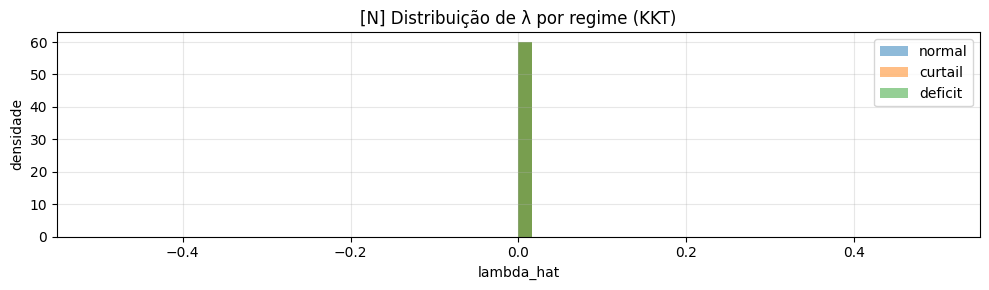

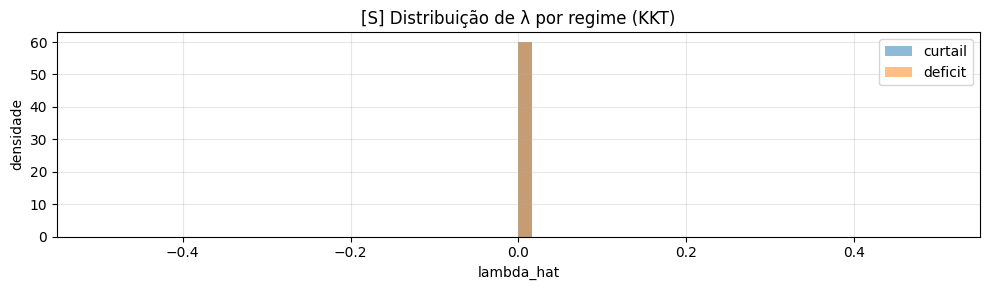

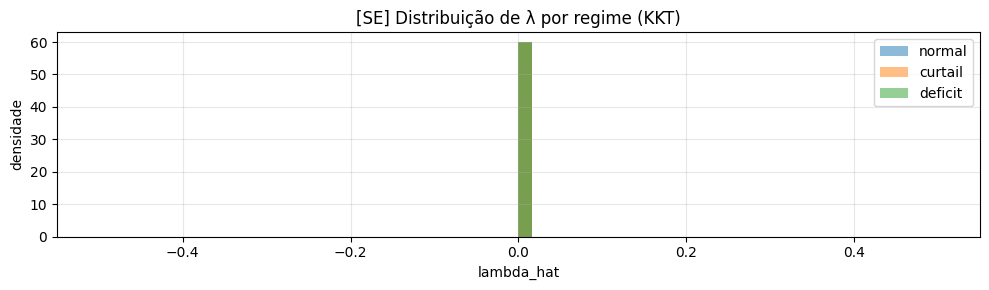

In [62]:
def classify_regime(df, eps=1e-6):
    reg = np.full(len(df), "normal", dtype=object)
    reg[df["c_hat"].values > eps] = "curtail"
    reg[df["u_hat"].values > eps] = "deficit"
    return reg

pred2 = pred.copy()
pred2["regime"] = classify_regime(pred2)

for ss, g in pred2.groupby("id_subsistema"):
    plt.figure(figsize=(10,3))
    for reg in ["normal","curtail","deficit"]:
        x = g[g["regime"]==reg]["lambda_hat"].values
        if len(x)>0:
            plt.hist(x, bins=60, alpha=0.5, density=True, label=reg)
    plt.title(f"[{ss}] Distribuição de λ por regime (KKT)")
    plt.xlabel("lambda_hat")
    plt.ylabel("densidade")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


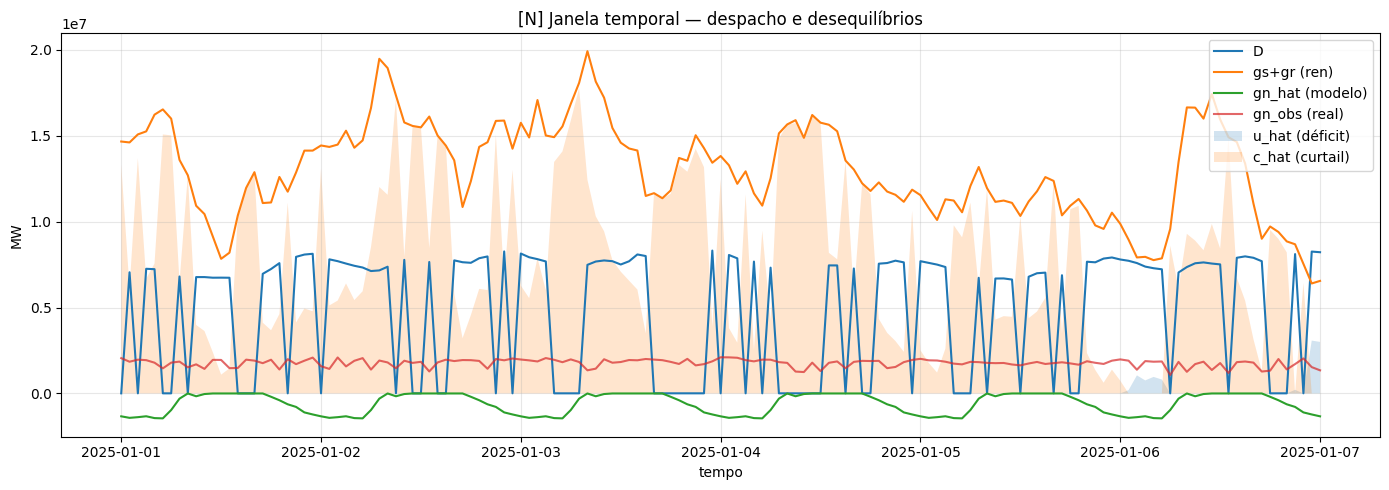

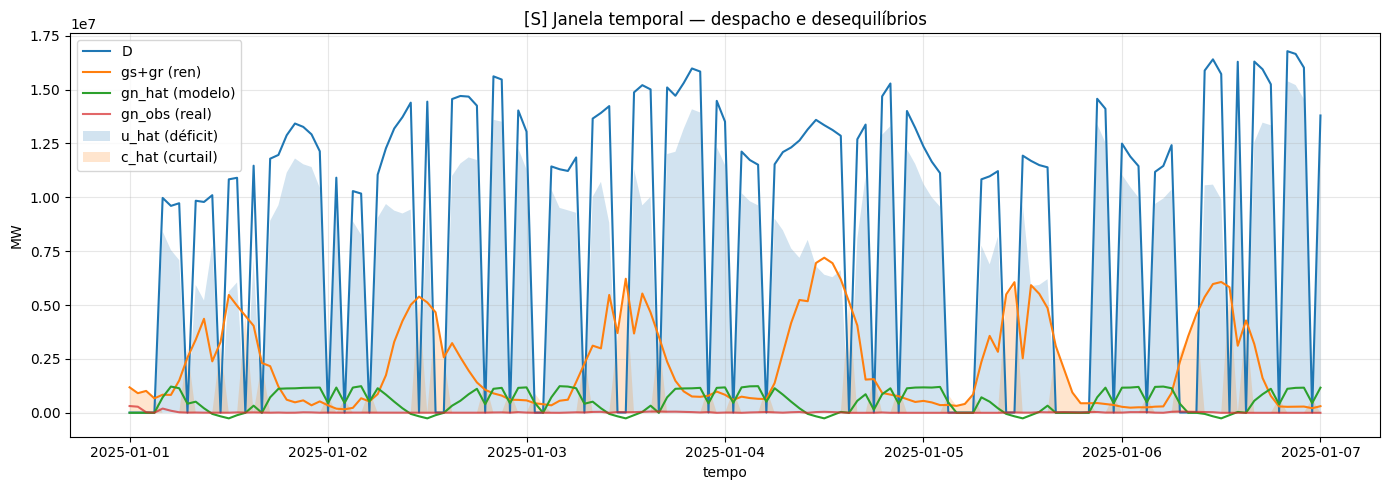

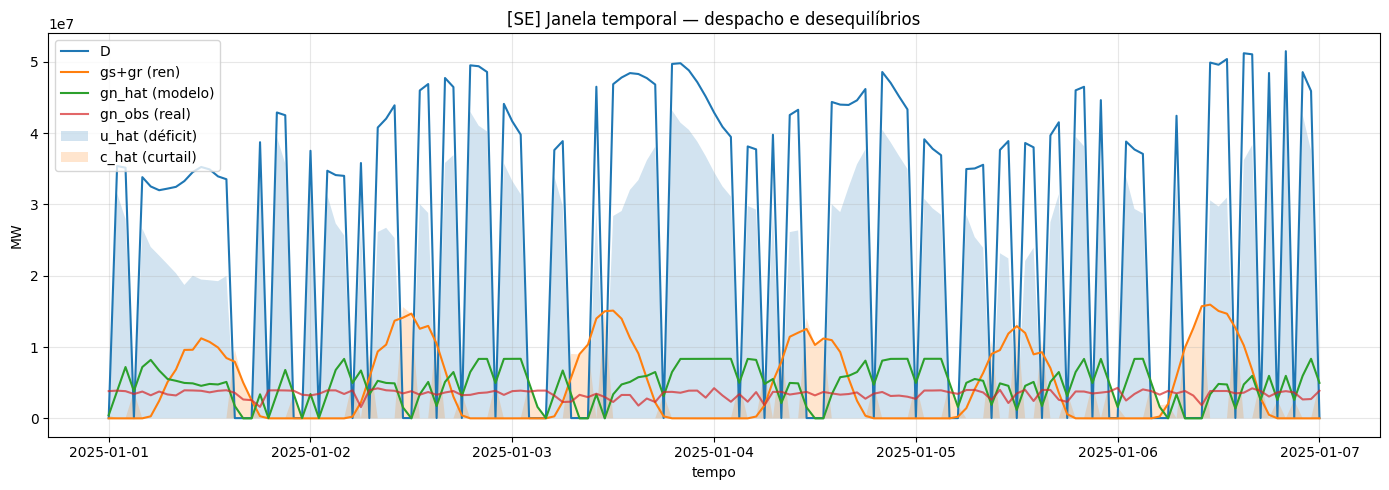

In [63]:
def plot_window(df, ss, start=None, end=None):
    g = df[df["id_subsistema"]==ss].copy().sort_values("din_instante")
    if start: g = g[g["din_instante"]>=pd.to_datetime(start)]
    if end:   g = g[g["din_instante"]<=pd.to_datetime(end)]
    if len(g)==0:
        print("Janela vazia"); return

    t = g["din_instante"]
    plt.figure(figsize=(14,5))
    plt.plot(t, g["D"], label="D", linewidth=1.5)
    plt.plot(t, g["gs"]+g["gr"], label="gs+gr (ren)", linewidth=1.5)
    plt.plot(t, g["gn_hat"], label="gn_hat (modelo)", linewidth=1.5)
    plt.plot(t, g["gn_obs"], label="gn_obs (real)", alpha=0.7)
    plt.fill_between(t, 0, g["u_hat"], alpha=0.2, label="u_hat (déficit)")
    plt.fill_between(t, 0, g["c_hat"], alpha=0.2, label="c_hat (curtail)")
    plt.title(f"[{ss}] Janela temporal — despacho e desequilíbrios")
    plt.xlabel("tempo")
    plt.ylabel("MW")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

for ss in sorted(pred2["id_subsistema"].unique()):
    plot_window(pred2, ss, start="2025-01-01", end="2025-01-07")


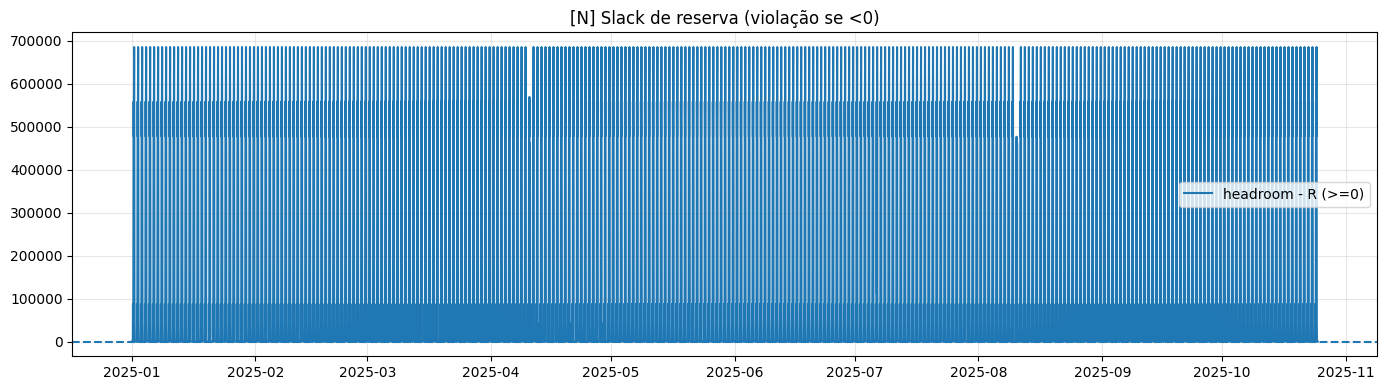

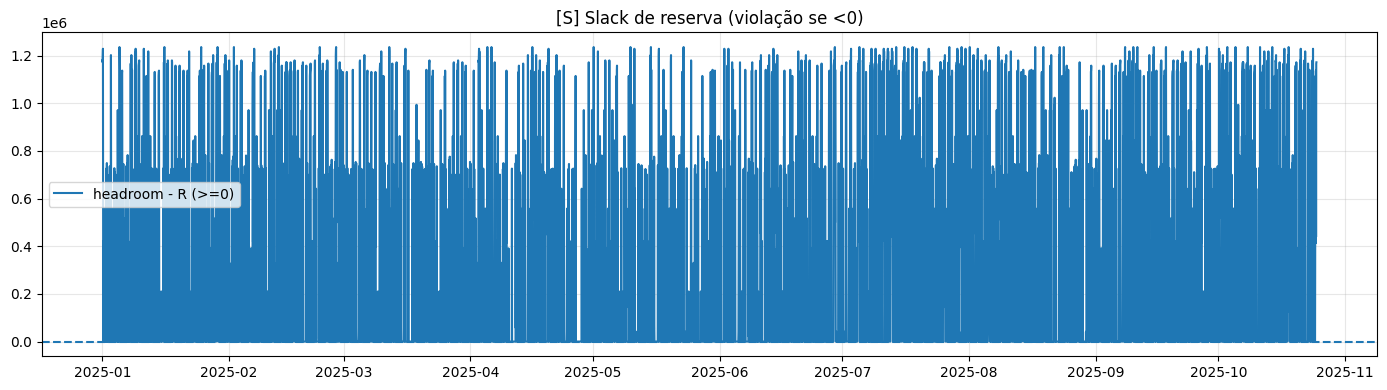

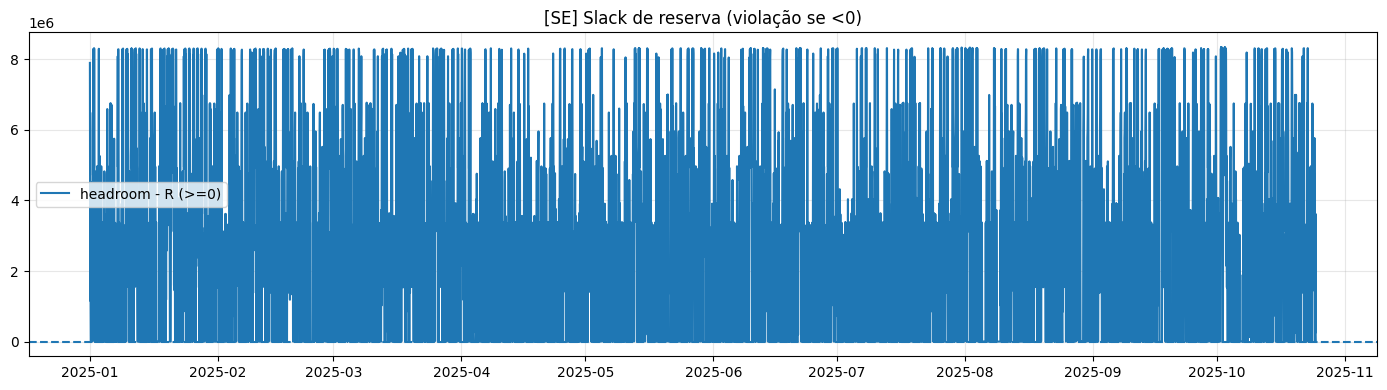

In [64]:
def plot_slacks(df, ss):
    g = df[df["id_subsistema"]==ss].sort_values("din_instante").copy()
    # rampa
    dg = np.r_[np.nan, np.diff(g["gn_hat"].values)]
    g["abs_dg"] = np.abs(dg)

    plt.figure(figsize=(14,4))
    plt.plot(g["din_instante"], g["reserve_slack"], label="headroom - R (>=0)")
    plt.axhline(0, linestyle="--")
    plt.title(f"[{ss}] Slack de reserva (violação se <0)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

for ss in sorted(pred2["id_subsistema"].unique()):
    plot_slacks(pred2, ss)


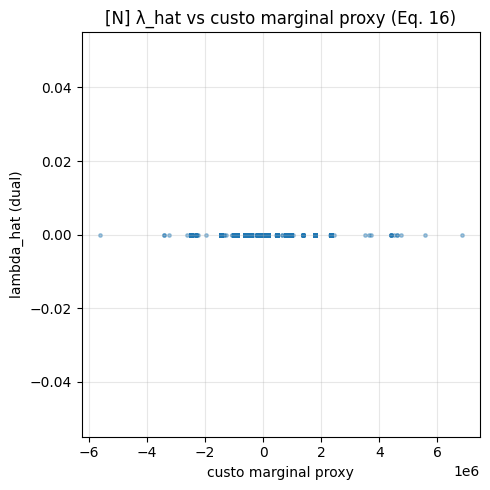

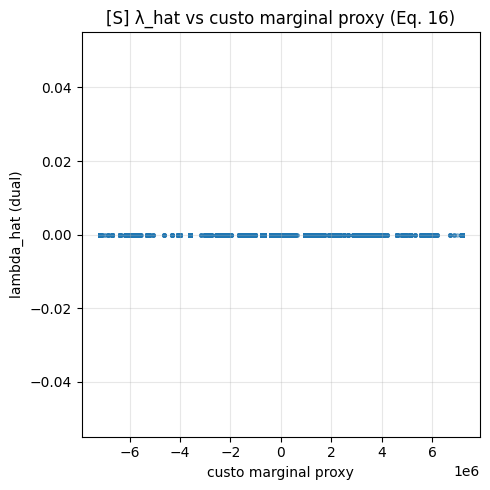

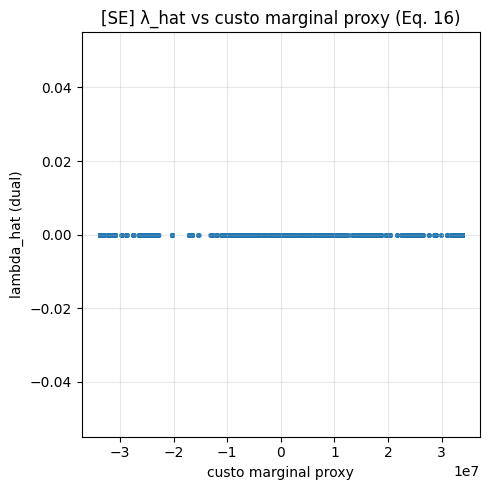

In [65]:
def marginal_cost_proxy(g, c1=0.0, c2=1e-4, gamma=5.0):
    g = np.asarray(g)
    gm1 = np.r_[g[0], g[:-1]]
    gp1 = np.r_[g[1:], g[-1]]
    return c1 + c2*g + gamma*(2*g - gm1 - gp1)

for ss, g in pred2.groupby("id_subsistema"):
    g = g.sort_values("din_instante")
    mc = marginal_cost_proxy(g["gn_hat"].values, c1=0.0, c2=1e-4, gamma=5.0)

    plt.figure(figsize=(5,5))
    plt.scatter(mc, g["lambda_hat"].values, s=6, alpha=0.4)
    plt.title(f"[{ss}] λ_hat vs custo marginal proxy (Eq. 16)")
    plt.xlabel("custo marginal proxy")
    plt.ylabel("lambda_hat (dual)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [66]:
def fit_params_grid(panel_ss, gamma_grid, c2_grid, pi_u=1e4, pi_c=10.0, kappa=1.0):
    # prepara sigma_eps por hora
    tmp = compute_sigma_eps(panel_ss, mode="hourly")
    gdf = panel_ss.merge(tmp, on=["din_instante","id_subsistema"], how="left").fillna({"sigma_eps":0.0})
    gdf = gdf.sort_values("din_instante").reset_index(drop=True)

    Kn, rho = estimate_Kn_rho(gdf["gn_obs"].values)
    gs, gr, D, sig = gdf["gs"].values, gdf["gr"].values, gdf["D"].values, gdf["sigma_eps"].values
    g0 = float(gdf["gn_obs"].iloc[0])

    best = None
    for gamma in gamma_grid:
        for c2 in c2_grid:
            params = Params(Kn=Kn, rho=rho, gamma=float(gamma), c2=float(c2), pi_u=pi_u, pi_c=pi_c, kappa=kappa)
            gn_hat, c_hat, u_hat, R_hat, lam_hat = dispatch_social(gs, gr, D, sig, params, g0=g0, force_cvxpy=True)
            rmse = float(np.sqrt(np.mean((gn_hat - gdf["gn_obs"].values)**2)))
            bal  = float(np.sqrt(np.mean((gs+gr+gn_hat - (D+c_hat-u_hat))**2)))

            score = rmse + 10.0*bal
            rec = {"gamma":gamma,"c2":c2,"rmse_gn":rmse,"balance_rmse":bal,"score":score}
            if best is None or rec["score"] < best["score"]:
                best = rec
    return best

gamma_grid = [0.5, 1.0, 2.0, 5.0, 10.0]
c2_grid    = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

best_by_ss = []
for ss, g in panel.groupby("id_subsistema"):
    g = g.sort_values("din_instante").copy()
    best = fit_params_grid(g, gamma_grid, c2_grid)
    best["subsistema"] = ss
    best_by_ss.append(best)

best_by_ss = pd.DataFrame(best_by_ss).sort_values("subsistema")
best_by_ss


,gamma,c2,rmse_gn,balance_rmse,score,subsistema
0,0.5,0.00001,3.166246e+06,2.257323e-11,3.166246e+06,N
1,0.5,0.00001,7.287233e+05,4.721799e-10,7.287233e+05,S
2,0.5,0.00001,3.082664e+06,1.328702e-09,3.082664e+06,SE
